<a href="https://colab.research.google.com/github/fidelsteiner/HiRISKDashboards/blob/main/HiRISK_climatologies/ERA5_L_temperature_climatology_GEE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Point scale annual temperature cycles
##### developed for [HiRISK](https://hirisk.org/risk-assessments/) based on code by [amrit thapa](https://amrit-thapa-2044.github.io/)

## Data source
https://developers.google.com/earth-engine/datasets/catalog/ECMWF_ERA5_LAND_DAILY_AGGR

In [3]:
import ee
ee.Authenticate()
ee.Initialize(project='ee-jffsteiner') # add project name/EE account

In [4]:
import pandas as pd
from plotnine import* # asterisk (*) means load all functions from plotnine
from mizani.breaks import date_breaks
from mizani.formatters import date_format
from google.colab import files

In [6]:
# Download ERA5 Data (locally stores the data as a .csv)

def ee_array_to_df(arr, list_of_bands):
    """Transforms client-side ee.Image.getRegion array to pandas.DataFrame."""
    df = pd.DataFrame(arr)

    # Rearrange the header.
    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns=headers)

    # Remove rows without data inside.
    df = df[['longitude', 'latitude', 'time', *list_of_bands]].dropna()

    # Convert the data to numeric values.
    for band in list_of_bands:
        df[band] = pd.to_numeric(df[band], errors='coerce')

    # Convert the time field into a datetime.
    df['datetime'] = pd.to_datetime(df['time'], unit='ms')

    # Keep the columns of interest.
    df = df[['time', 'datetime', *list_of_bands]]

    return df

def download_era5L_data(start_year, end_year, lon, lat, variable, scale=30000):
    # Define the location of interest as point geometry
    my_point = ee.Geometry.Point(lon, lat)

    # Import the ERA5 image collection.
    ERA5 = ee.ImageCollection("ECMWF/ERA5_LAND/DAILY_AGGR")

    # Initialize an empty list to store dataframes
    dfs = []

    # Loop through different start years, every 1 years apart
    for start_year_i in range(start_year, end_year, 1):
        # Initial date of interest (inclusive).
        i_date = f'{start_year_i}-01-01'

        # Final date of interest (exclusive).
        f_date = f'{start_year_i + 10}-01-01'

        # Selection of appropriate bands and dates.
        ERA5_my_variable = ERA5.select(variable).filterDate(i_date, f_date)

        # Get the data for the pixel intersecting our point.
        ERA5_my_variable_my_point = ERA5_my_variable.getRegion(my_point, scale).getInfo()

        df_era5_my_point = ee_array_to_df(ERA5_my_variable_my_point, [variable])
        df_daily_final = df_era5_my_point[['datetime', variable]]

        # Append dataframe to the list
        dfs.append(df_daily_final)

    # Merge all dataframes into a single dataframe
    merged_df = pd.concat(dfs, ignore_index=True)

    # Define output filename
    output_filename = f"ERA5L_daily_{variable}_lon_{lon}_lat_{lat}_{start_year}_{end_year}.csv"
    print('Output file name is: ', output_filename)

    # Convert merged dataframe to CSV
    merged_df.to_csv(output_filename, encoding='utf-8-sig', index=False)

    print("CSV file created successfully.")

    files.download(output_filename)
    return merged_df,variable, lon,lat,start_year,end_year

# Example usage:
# download_era5_data(1950, 2000, 85.562713, 28.156868, 'snow_depth')


In [7]:
# Choose variable and time period
my_var='temperature_2m'
my_lon= 74.578228
my_lat= 36.346578
df=download_era5L_data(2000, 2025, my_lon, my_lat, my_var) #temperature_2m, snow_depth,temperature_2m_max

Output file name is:  ERA5L_daily_temperature_2m_lon_74.578228_lat_36.346578_2000_2025.csv
CSV file created successfully.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [8]:
# extract
df_data = df[0].copy()
df_data[my_var]=df_data[my_var]-273.15

# Extract year and day of year (DOY)
df_data['year'] = df_data['datetime'].dt.year
df_data['mon'] = df_data['datetime'].dt.month
df_data['doy'] = df_data['datetime'].dt.dayofyear

# Sort years and get unique ones
unique_years = sorted(df_data['year'].unique())

# get first year
first_year=unique_years[0]

# Get last year
last_year = unique_years[-1]

# Get second last year
second_last_year = unique_years[-2]

# Separate data for 2025 and others
df_last_year = df_data[df_data['year'] == last_year]
df_others = df_data[df_data['year'] != last_year]

In [9]:
# Group by DOY and compute statistics
temp_stats_by_doy = (
    df_data.groupby('doy')['temperature_2m']
    .agg([
        'mean',
        'std',
        lambda x: x.quantile(0.10),
        lambda x: x.quantile(0.90)
    ])
    .reset_index()
)

# Rename columns for clarity
temp_stats_by_doy.columns = ['doy', 'mean', 'std', 'q10', 'q90']


/tmp/ipython-input-3447628438.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


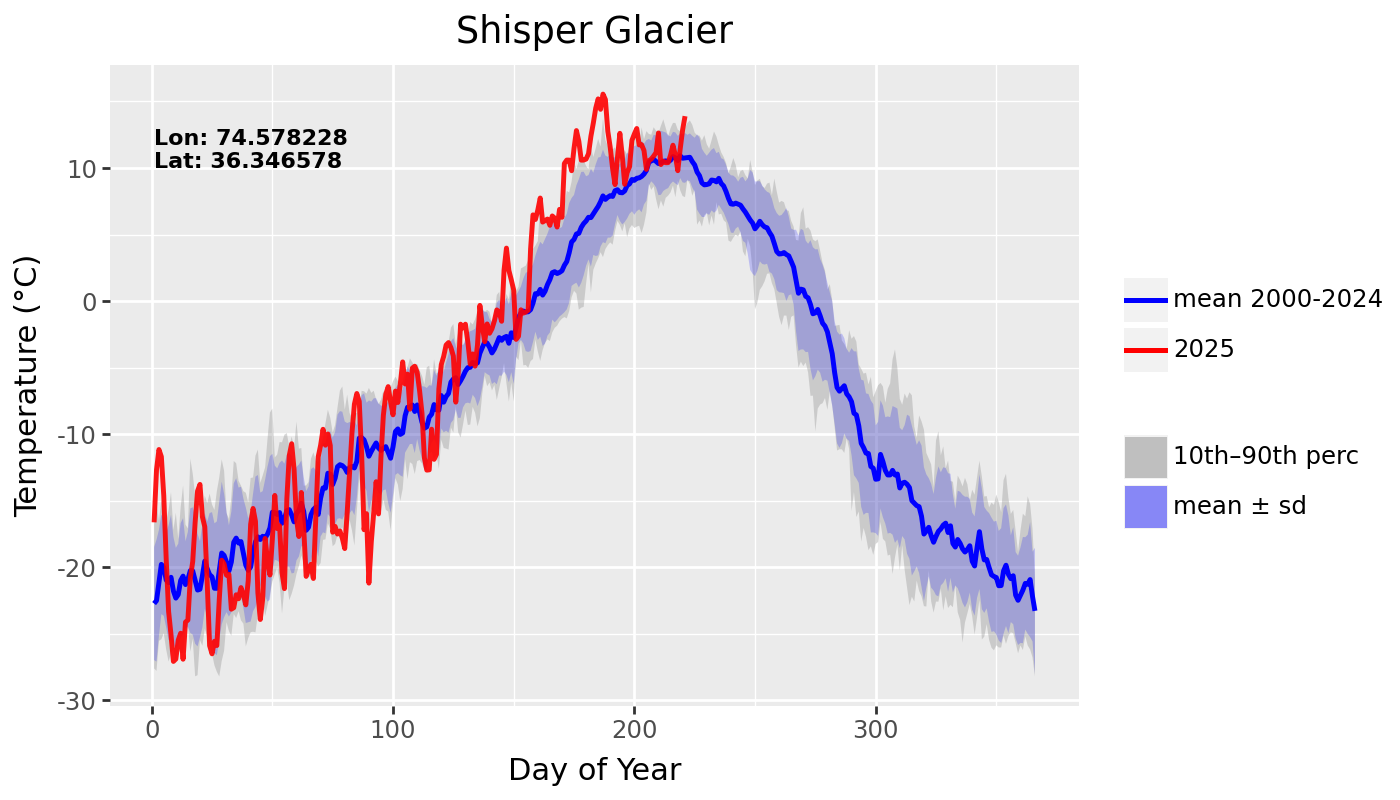

/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 7 x 4 in image.
/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: temperature_2m_climatology_74.578228_36.346578.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [13]:
from plotnine import *

# Add label columns for ribbons
temp_stats_by_doy['interval'] = '10th–90th perc'
temp_stats_by_doy['std_band'] = 'mean ± sd'

df_last_year['label'] = str(last_year)

p=(
    ggplot(temp_stats_by_doy) +

    # 10th–90th percentile ribbon (gray)
    geom_ribbon(
        aes(x='doy', ymin='q10', ymax='q90', fill='interval'),
        alpha=0.3
    ) +

    # Mean ± std deviation ribbon (light blue)
    geom_ribbon(
        aes(x='doy', ymin='mean - std', ymax='mean + std', fill='std_band'),
        alpha=0.2
    ) +

    # Mean temperature line
    geom_line(
        aes(x='doy', y='mean', color=f'"mean {first_year}-{second_last_year}"'),
        size=1
    ) +

    # Line for most recent year (e.g. 2025)
    geom_line(
        df_last_year,
        aes(x='doy', y=my_var, color='label'),
        size=1,
        alpha=0.9
    ) +
        scale_color_manual(
        values={
            '2025': 'red',
            f'mean {first_year}-{second_last_year}': 'blue'
        },
        name=' '
    ) +

    scale_fill_manual(
        values={
            '10th–90th %': 'gray',
            'mean ± sd': 'blue'
        },
        name=' '
    ) +

    #theme_minimal() +
    labs(x='Day of Year', y='Temperature (°C)', title='Shisper Glacier') +
    theme(legend_position='right',figure_size=(7, 4))+
     annotate(
        'text',
        x=temp_stats_by_doy['doy'].min(),
        y=temp_stats_by_doy['mean'].max() + 2,
        label=f'Lon: {my_lon}\nLat: {my_lat}',
        ha='left',
        va='top',
        size=8,
        fontweight='bold'
    )
)

p.show()

# Save as PNG with 350 DPI
png_out=f'{my_var}_climatology_{my_lon}_{my_lat}.png'
p.save(png_out, dpi=350)

files.download(png_out)